In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
import os
import glob
import librosa
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

In [8]:
!unrar x /content/drive/MyDrive/Datasets/Raw_audio.rar /content/drive/MyDrive/Datasets/Raw_audio_extracted/


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/drive/MyDrive/Datasets/Raw_audio.rar

Creating    /content/drive/MyDrive/Datasets/Raw_audio_extracted       OK
Creating    /content/drive/MyDrive/Datasets/Raw_audio_extracted/Raw Audio  OK
Creating    /content/drive/MyDrive/Datasets/Raw_audio_extracted/Raw Audio/car_crash  OK
Extracting  /content/drive/MyDrive/Datasets/Raw_audio_extracted/Raw Audio/car_crash/0-0.wav       0%  OK 
Extracting  /content/drive/MyDrive/Datasets/Raw_audio_extracted/Raw Audio/car_crash/0-1.wav       0%  OK 
Extracting  /content/drive/MyDrive/Datasets/Raw_audio_extracted/Raw Audio/car_crash/0-12.wav       0%  OK 
Extracting  /content/drive/MyDrive/Datasets/Raw_audio_extracted/Raw Audio/car_crash/0-5.wav       0%  OK 
Extracting  /content/drive/MyDrive/Datasets/Raw_audio_extracted/Raw Audio/car_crash/0-6.wav       0%  OK 
Extracting  /content/drive/MyDrive/Datasets/Ra

In [22]:
def extract_features(audio_path, n_mfcc=13):
    try:
        y, sr = librosa.load(audio_path, sr=44100)
        mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc).T, axis=0)
        chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
        spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr).T, axis=0)
        features = np.hstack([mfccs, chroma, spectral_contrast])
        return features
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

In [23]:
# all audio files and labels
def load_data(audio_dir):
    features = []
    labels = []
    for class_dir in os.listdir(audio_dir):
        class_path = os.path.join(audio_dir, class_dir)
        if not os.path.isdir(class_path):
            continue
        for audio_path in glob.glob(os.path.join(class_path, "*.wav")):
            feature = extract_features(audio_path)
            if feature is not None:
                features.append(feature)
                labels.append(class_dir)
    return np.array(features), np.array(labels)

In [24]:
# Load data
audio_dir = '/content/drive/MyDrive/Datasets/Raw_audio_extracted/Raw Audio/'
X, y = load_data(audio_dir)
print(f"Features shape: {X.shape}, Labels shape: {y.shape}")

/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Features shape: (1240, 32), Labels shape: (1240,)


In [25]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
print(f"Training set shape: {X_train.shape}, Testing set shape: {X_test.shape}")


Training set shape: (992, 32), Testing set shape: (248, 32)


In [26]:
# Feature normalization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [27]:
# defining the model
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
# Model Training
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.2755 - loss: 2.5404 - val_accuracy: 0.6008 - val_loss: 1.5238
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5833 - loss: 1.3340 - val_accuracy: 0.6734 - val_loss: 1.2671
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6945 - loss: 0.9292 - val_accuracy: 0.7016 - val_loss: 1.0792
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7417 - loss: 0.7989 - val_accuracy: 0.7863 - val_loss: 0.9160
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7392 - loss: 0.7661 - val_accuracy: 0.8024 - val_loss: 0.7885
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7749 - loss: 0.6764 - val_accuracy: 0.7863 - val_loss: 0.7111
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7801 - loss: 0.6101 - val_accuracy: 0.8306 - val_loss: 0.6205
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8224 - loss: 0.5158 - val_accuracy: 0.8427 - val_loss

In [29]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8685 - loss: 0.4459 
Test Accuracy: 0.88


In [30]:
# Save the model
model.save('audio_classification_model.h5')

# Load the model
loaded_model = tf.keras.models.load_model('audio_classification_model.h5')


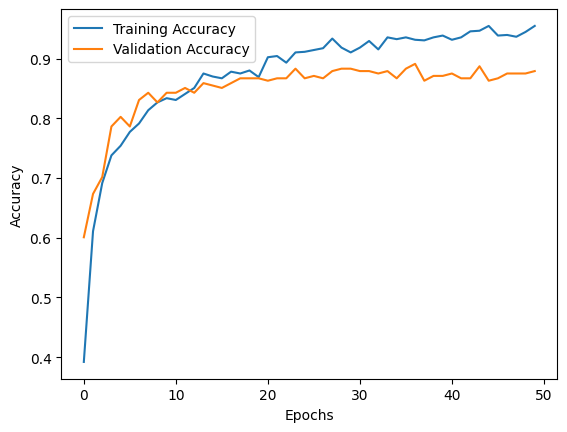

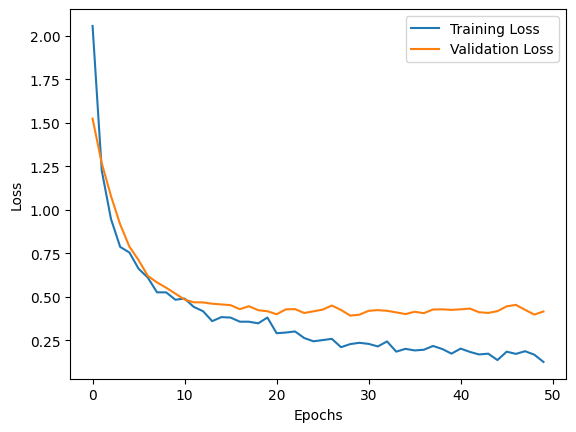

In [31]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [32]:
new_audio_path = '/content/drive/MyDrive/Datasets/Raw_audio_extracted/Raw Audio/car_crash/0-12.wav'
new_features = scaler.transform(extract_features(new_audio_path).reshape(1, -1))
prediction = model.predict(new_features)
predicted_class = label_encoder.inverse_transform([np.argmax(prediction)])
print(f"Predicted class: {predicted_class[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Predicted class: car_crash
